In [160]:
#!/usr/bin/env python
# coding=utf-8

# Detects and creates the collaboration graph based on the clustering results
# Evaluates content creator assignments, collaborations between channel, networks, categories and popularities

import pandas as pa 
import numpy as np

import json
import os
import networkx as nx
import pygraphviz as gz
from networkx.drawing.nx_pydot import write_dot
import math

from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import itertools

import csv
from sqlalchemy import exists, func

from database import *

from matplotlib import pylab, pyplot
from matplotlib import dates

import seaborn as sns
sns.set(color_codes=True)

from scipy import stats, integrate

from datetime import datetime, timedelta, date

date_format = '%Y-%m-%dT%H:%M:%S.%fZ'
date_format2 = '%Y-%m-%d %H:%M:%S'

plt.style.use(['seaborn-paper'])
sns.set_style("whitegrid")
#plt.rc('font', family='serif', serif='Charter')
plt.rc('font', family='serif', serif='DejaVu Serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x_width  = 6.8898
x_height = x_width / 1.618

s_width  = 3.4449
s_height = s_width / 1.618

def save_plot(name, fig, width, height):
    fig.tight_layout()
    fig.set_size_inches(width, height)
    #f.subplots_adjust(top=0.86)

    fig.savefig(CDIR+'/'+name, bbox_inches="tight")
    #plt.savefig(CDIR+'/video_view_percentages.pdf', bbox_inches="tight")

In [161]:
DIR = '../../data/data_evaluation_2'
CDIR = '../../data/data_evaluation_2/charts'

db = YTDatabase()

In [3]:
df_channel = pa.read_csv(DIR+r'/df_channel_statistics_first_day.txt', sep=str('\t'), encoding='utf-8')


In [4]:
df_channel= df_channel.set_index(['id'])

df_channel.loc[df_channel['network'] == 'Maker_Studios', 'network'] = 'Maker Studios'
#Fullscreen managed
df_channel.loc[df_channel['network'] == 'Fullscreen managed', 'network'] = 'Fullscreen'
df_channel.head()

,topicIds,network,viewCount,subscriberCount,videoCount,commentCount,category,popularity
id,,,,,,,,
UC__Pj66OeDibNZNN__L913g,Music,None,3253022,23029,967,0,Entertainment,2
UC__PZLSRGtUQiTtvm3hPoEQ,Movies,BroadbandTV,310896,5878,144,0,Entertainment,1
UC__rmdgxs3ZF0zK_he7Tmig,Lifestyle,None,1291254,8146,294,121,How-to & Style,1
UC_-CxgsxX0tpnm24WO-797Q,Lifestyle,Maker Studios,625545,18990,67,101,How-to & Style,2
UC_1FUFB6TlGeGOyDI4ikkzg,Movies,BroadbandTV,89020205,106760,288,0,Entertainment,3


In [5]:

# read collabs from database table
# session.query(VideoFaceCluster)
with db._session_scope(False) as session:

    df_feature_cluster = pa.read_sql(session.query(VideoFeatures.id, VideoFeatures.videoID, VideoFeatures.duration, Video.channelID, VideoFaceCluster.cluster).filter( (VideoFaceCluster.featureID == VideoFeatures.id) & (VideoFeatures.videoID == Video.id) ).statement, db.engine)

print df_feature_cluster.head()
print '\nnumber of feature', len(df_feature_cluster)
print 'number of channels:', df_feature_cluster['channelID'].nunique()
print 'number of videos', df_feature_cluster['videoID'].nunique()
print 'number of clusters:', df_feature_cluster['cluster'].nunique()

       id      videoID  duration                 channelID  cluster
0  159389  gjce2lOMhXs   2223.10  UC--BMyA2X4a9PGAo3lTuopg     2857
1  159391  gjce2lOMhXs   1633.47  UC--BMyA2X4a9PGAo3lTuopg     2857
2  159392  gjce2lOMhXs   1643.81  UC--BMyA2X4a9PGAo3lTuopg     2857
3  159395  gjce2lOMhXs   1350.18  UC--BMyA2X4a9PGAo3lTuopg     3527
4  159396  gjce2lOMhXs   1128.79  UC--BMyA2X4a9PGAo3lTuopg     3527

number of feature 37861
number of channels: 1488
number of videos 22048
number of clusters: 3803


In [6]:
# create df_feature_cluster with react videos filtered

# sql like 'react', reaction?

# read collabs from database table
# session.query(VideoFaceCluster)
with db._session_scope(False) as session:

    df_filtered_cluster = pa.read_sql(session.query(VideoFeatures.id, VideoFeatures.videoID, VideoFeatures.duration, Video.channelID, VideoFaceCluster.cluster).filter( (VideoFaceCluster.featureID == VideoFeatures.id) & (VideoFeatures.videoID == Video.id) & (~Video.title.like(u'%react%')) ).statement, db.engine)

print df_filtered_cluster.head()
print '\nnumber of feature', len(df_filtered_cluster)
print 'number of channels:', df_filtered_cluster['channelID'].nunique()
print 'number of videos', df_filtered_cluster['videoID'].nunique()
print 'number of clusters:', df_filtered_cluster['cluster'].nunique()

       id      videoID  duration                 channelID  cluster
0  159389  gjce2lOMhXs   2223.10  UC--BMyA2X4a9PGAo3lTuopg     2857
1  159391  gjce2lOMhXs   1633.47  UC--BMyA2X4a9PGAo3lTuopg     2857
2  159392  gjce2lOMhXs   1643.81  UC--BMyA2X4a9PGAo3lTuopg     2857
3  159395  gjce2lOMhXs   1350.18  UC--BMyA2X4a9PGAo3lTuopg     3527
4  159396  gjce2lOMhXs   1128.79  UC--BMyA2X4a9PGAo3lTuopg     3527

number of feature 36162
number of channels: 1482
number of videos 21271
number of clusters: 3727


number of videos for channel: 36
cluster in >10% videos:
Series([], Name: cluster, dtype: float64)


<IPython.core.display.Javascript object>


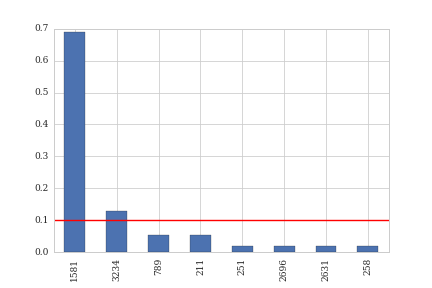

      relative_counts                 channelID
1581         0.690909  UC-lHJZR3Gqxm24_Vd_AJ5Yw
3234         0.127273  UC-lHJZR3Gqxm24_Vd_AJ5Yw
789          0.054545  UC-lHJZR3Gqxm24_Vd_AJ5Yw
211          0.054545  UC-lHJZR3Gqxm24_Vd_AJ5Yw
251          0.018182  UC-lHJZR3Gqxm24_Vd_AJ5Yw
2696         0.018182  UC-lHJZR3Gqxm24_Vd_AJ5Yw
2631         0.018182  UC-lHJZR3Gqxm24_Vd_AJ5Yw
258          0.018182  UC-lHJZR3Gqxm24_Vd_AJ5Yw
number of videos for channel, filtered: 35
cluster in >10% videos, filtered:
Series([], Name: cluster, dtype: float64)


<IPython.core.display.Javascript object>


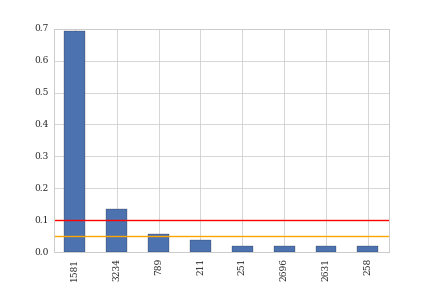

      relative_counts                 channelID
1581         0.692308  UC-lHJZR3Gqxm24_Vd_AJ5Yw
3234         0.134615  UC-lHJZR3Gqxm24_Vd_AJ5Yw
789          0.057692  UC-lHJZR3Gqxm24_Vd_AJ5Yw
211          0.038462  UC-lHJZR3Gqxm24_Vd_AJ5Yw
251          0.019231  UC-lHJZR3Gqxm24_Vd_AJ5Yw
2696         0.019231  UC-lHJZR3Gqxm24_Vd_AJ5Yw
2631         0.019231  UC-lHJZR3Gqxm24_Vd_AJ5Yw
258          0.019231  UC-lHJZR3Gqxm24_Vd_AJ5Yw


In [7]:
# testing filtering with 10% mark

from sklearn.preprocessing import normalize

channel_groups = df_feature_cluster.groupby('channelID')
filtered_channel_groups = df_filtered_cluster.groupby('channelID')

df_test = pa.DataFrame()
df_test_filtered = pa.DataFrame()

print 'number of videos for channel:', df_feature_cluster[df_feature_cluster.channelID == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['videoID'].nunique()
f = df_feature_cluster[df_feature_cluster.channelID == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['videoID'].nunique() * 0.1
counts = channel_groups.get_group('UC-lHJZR3Gqxm24_Vd_AJ5Yw')['cluster'].value_counts(normalize=True)
df_test['relative_counts'] = counts
df_test['channelID'] = 'UC-lHJZR3Gqxm24_Vd_AJ5Yw'
print 'cluster in >10% videos:\n', counts[counts >= f]
fig = plt.figure()
ax = counts.plot(kind='bar')
ax.axhline(0.1, color='red')
print df_test

print 'number of videos for channel, filtered:', df_filtered_cluster[df_filtered_cluster.channelID == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['videoID'].nunique()
f = df_filtered_cluster[df_filtered_cluster.channelID == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['videoID'].nunique() * 0.1
counts = filtered_channel_groups.get_group('UC-lHJZR3Gqxm24_Vd_AJ5Yw')['cluster'].value_counts(normalize=True)
df_test_filtered['relative_counts'] = counts
df_test_filtered['channelID'] = 'UC-lHJZR3Gqxm24_Vd_AJ5Yw'
print 'cluster in >10% videos, filtered:\n', counts[counts >= f]
fig = plt.figure()
ax = counts.plot(kind='bar')
ax.axhline(0.1, color='red')
ax.axhline(0.05, color='orange')
print df_test_filtered


In [8]:
# create table with relative cluster counts per channel, plot dist

df_relative_counts = pa.DataFrame()
df_number_videos = []

for name, group in filtered_channel_groups:
    
    df_test = pa.DataFrame()

    df_number_videos.append(df_filtered_cluster[df_filtered_cluster.channelID == name]['videoID'].nunique())
    counts = group['cluster'].value_counts(normalize=True)
    df_test['relative_counts'] = counts
    df_test['channelID'] = name
    df_relative_counts = df_relative_counts.append(df_test)

df_number_videos = pa.DataFrame(df_number_videos)
df_relative_counts.head()

,relative_counts,channelID
2858,0.36,UC--BMyA2X4a9PGAo3lTuopg
2859,0.24,UC--BMyA2X4a9PGAo3lTuopg
3526,0.16,UC--BMyA2X4a9PGAo3lTuopg
2857,0.12,UC--BMyA2X4a9PGAo3lTuopg
3527,0.12,UC--BMyA2X4a9PGAo3lTuopg


<IPython.core.display.Javascript object>


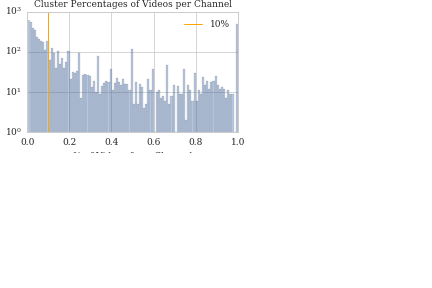

<IPython.core.display.Javascript object>


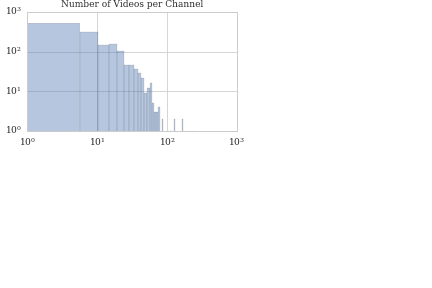

In [9]:
fig = plt.figure()
ax = sns.distplot(df_relative_counts['relative_counts'], kde=False, bins=100)
#ax.axvline(0.25, color='yellow', label='25%', linewidth=0.5)
ax.axvline(0.1, color='orange', label='10%', linewidth=1.0)
#ax.axvline(0.05, color='red', label='5%', linewidth=0.8)
ax.set_xlabel('% of Videos from Channel')
ax.set_ylabel('Cluster')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.title('Cluster Percentages of Videos per Channel')

save_plot('channel_video_cluster_percentages.pdf', fig, s_width, s_height)

fig = plt.figure()
ax = sns.distplot(df_number_videos, kde=False)
ax.set_xlabel('Number of Videos')
ax.set_ylabel('Channel')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Number of Videos per Channel')


save_plot('channel_nof_videos.pdf', fig, s_width, s_height)

In [10]:
cluster = {}

label = df_feature_cluster['cluster'].unique()

for l in label:
    ftl = df_feature_cluster[df_feature_cluster.cluster == l]
    groups = ftl.groupby(['channelID'])
    vcounts = groups.videoID.nunique()
    vtcounts = groups.videoID.unique()
    vcounts = vcounts.sort_values(ascending=False)
    vs = vcounts.index
    vtcounts = vtcounts.reindex(vs)
    # TODO get average(?) duration for collabs too
    cluster[l] = [(cid, nof, list(vids)) for (cid, nof), (cid2, vids) in zip(vcounts.iteritems(), vtcounts.iteritems())]
    #print l, cluster[l]
    #print vtcounts

    
filtered_cluster = {}

label = df_filtered_cluster['cluster'].unique()

for l in label:
    ftl = df_filtered_cluster[df_filtered_cluster.cluster == l]
    groups = ftl.groupby(['channelID'])
    vcounts = groups.videoID.nunique()
    vtcounts = groups.videoID.unique()
    vcounts = vcounts.sort_values(ascending=False)
    vs = vcounts.index
    vtcounts = vtcounts.reindex(vs)
    # TODO get average(?) duration for collabs too
    filtered_cluster[l] = [(cid, nof, list(vids)) for (cid, nof), (cid2, vids) in zip(vcounts.iteritems(), vtcounts.iteritems())]
    #print l, filtered_cluster[l]
    #print vtcounts

    

In [126]:
print cluster[3]
print filtered_cluster[4]

[(u'UC_1H9v258pXiyLDaW0R5exw', 2, [u'4wtezABa9cE', u'VHURP0gTZAI']), (u'UCY3NEq2LYrmdoGkevo9BH5A', 1, [u'FyLPJ5JWZYk'])]
[(u'UCcavSftXHgxLBWwLDm_bNvA', 1, [u'8WlbOBTSZCQ'])]


In [127]:
# create graph from collabs table

def create_graph(df, cluster):

    G = nx.DiGraph() # directed graph


    for l, cls in cluster.iteritems():
        if cls[0][1] >= math.ceil(df[df.channelID == cls[0][0]]['videoID'].nunique() * 0.1):
            mainc = cls[0][0]
            if G.has_node(mainc):
                if 'cluster' in G.node[mainc]:
                    G.node[mainc]['cluster'].append(str(l))
                else:
                    G.node[mainc]['cluster'] = [str(l)]

                    with db._session_scope(False) as session:
                        G.node[mainc]['network'] = session.query(Channel.network).filter(Channel.id == mainc).first()[0]

            else:
                with db._session_scope(False) as session:
                    network = session.query(Channel.network).filter(Channel.id == mainc).first()[0]
                G.add_node(mainc, cluster=[str(l)], network=network)

            for (c, n, v) in cls[1:]:
                G.add_edge(mainc, c, weight=int(n), cluster=str(l), videos=v)


    print '\nNodes:',len(G.nodes())
    print 'Edges:',len(G.edges())

    print 'Collabs (weight sum)', G.size(weight='weight')

    for x in G.nodes():
        if not 'network' in G.node[x]:
            with db._session_scope(False) as session:
                    G.node[x]['network'] = session.query(Channel.network).filter(Channel.id == x).first()[0]
        if not 'cluster' in G.node[x]:
            G.node[x]['cluster'] = ''
        #print G.node[x]['network']
        
    return G

G = create_graph(df_feature_cluster, cluster)

Gf = create_graph(df_filtered_cluster, filtered_cluster)


nx.write_gml(G, DIR+"/collab_detections_graph.gml")
nx.write_gml(Gf, DIR+"/filtered_collab_detections_graph.gml")

OperationalError: (_mysql_exceptions.OperationalError) (2006, 'MySQL server has gone away') [SQL: u'SELECT channel.network AS channel_network \nFROM channel \nWHERE channel.id = %s \n LIMIT %s'] [parameters: ('UCcavSftXHgxLBWwLDm_bNvA', 1)]

In [128]:
G = nx.read_gml(DIR+"/collab_detections_graph.gml")
Gf = nx.read_gml(DIR+"/filtered_collab_detections_graph.gml")

In [15]:
# compare graphs


# first compare nodes, which are present, which missing
Gf_missing = set()
for node in G.nodes():
    if not Gf.has_node(node):
        Gf_missing.add(node)

Gf_adds = set()
for node in Gf.nodes():
    if not G.has_node(node):
        Gf_adds.add(node)
        
with db._session_scope(False) as session:
    df_missing = pa.read_sql(session.query(Channel.title).filter((Channel.id.in_(Gf_missing))).statement, db.engine)
    df_adds = pa.read_sql(session.query(Channel.title).filter((Channel.id.in_(Gf_adds))).statement, db.engine)

print 'Missing:\n', df_missing
print 'Added:\n', df_adds

# then add all for edge comparision
Gfc = Gf.copy()
Gfc.add_nodes_from(list(Gf_missing))
   
Gc = G.copy()
Gc.add_nodes_from(list(Gf_adds))

Gc_diff = nx.difference(Gc, Gfc)
print '\nMissing edges:', len(Gc_diff.edges())
weight_sum = 0
for e in Gc_diff.edges():
        weight_sum += Gc.get_edge_data(e[0], e[1])['weight'] 
print 'Missing collabs:', weight_sum

Gfc_diff = nx.difference(Gfc, Gc)
print 'Added edges:',len(Gfc_diff.edges())
weight_sum = 0
for e in Gfc_diff.edges():
        weight_sum += Gfc.get_edge_data(e[0], e[1])['weight']
print 'Added collabs:', weight_sum


#for e in Gc_diff.edges():
#    with db._session_scope(False) as session:
#        fm = session.query(Channel.title).filter(Channel.id == e[0]).first()[0]
#        to = session.query(Channel.title).filter(Channel.id == e[1]).first()[0]
#        print fm,'->', to, ':', Gc.get_edge_data(e[0], e[1])

Missing:
                         title
0               Dante D'Angelo
1  Fine Brothers Entertainment
2       Great Gatsby the Corgi
3             YTWrestlingFacts
4                  SupTho Bros
Added:
          title
0  Bruna Farias

Missing edges: 62
Missing collabs: 116
Added edges: 7
Added collabs: 7


In [16]:
# get the number of clusters per channel -> number of content creator (not directly)
df_channel_cluster = pa.DataFrame(index=Gf.nodes())
df_channel_cluster['n_cluster'] = np.nan
#print df_channel_cluster

for node in Gf.nodes():
    #att = nx.get_node_attributes(Gf, 'cluster')
    #print att
    df_channel_cluster.ix[node,'n_cluster'] = len(Gf.node[node]['cluster'])
    
df_channel_cluster.describe()

,n_cluster
count,1462.000000
mean,2.993160
std,1.991414
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,35.000000


<IPython.core.display.Javascript object>


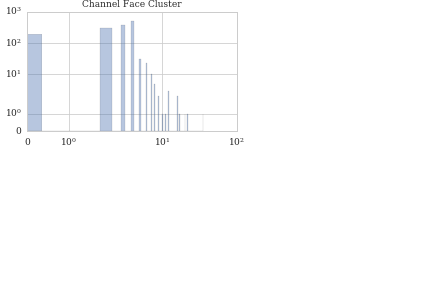

<IPython.core.display.Javascript object>


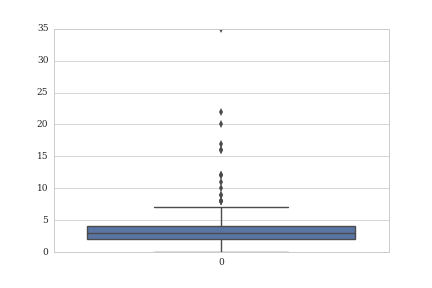

<IPython.core.display.Javascript object>


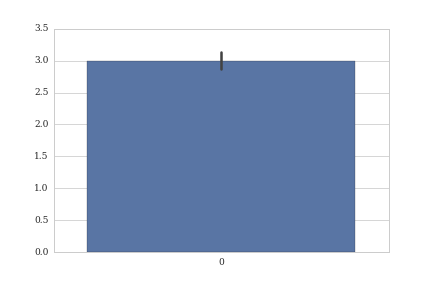

In [17]:
fig = plt.figure()
ax = sns.distplot(df_channel_cluster['n_cluster'], kde=False, bins=100)
ax.set_xlabel('Cluster')
ax.set_ylabel('Channel')
ax.set_xscale('symlog')
ax.set_yscale('symlog')

plt.title('Channel Face Cluster')
save_plot('channel_nof_face_cluster.pdf', fig, s_width, s_height)

fig = plt.figure()
sns.boxplot(data=df_channel_cluster['n_cluster'])

fig = plt.figure()
sns.barplot(data=df_channel_cluster['n_cluster'], ci=99)

In [18]:
degree_sequence=sorted(nx.degree(Gf).values(),reverse=True) # degree sequence
out_degree_sequence=sorted(Gf.out_degree().values(),reverse=True) # degree sequence
in_degree_sequence=sorted(Gf.in_degree().values(),reverse=True) # degree sequence


<IPython.core.display.Javascript object>


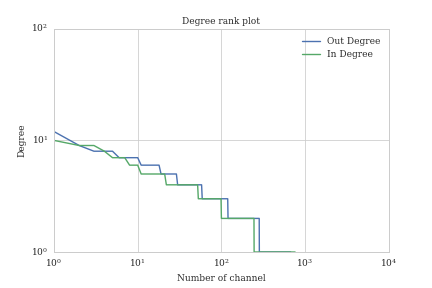

In [19]:
fig = plt.figure()
#plt.loglog(degree_sequence, label='Sum Degree')
plt.loglog(out_degree_sequence, label='Out Degree')
plt.loglog(in_degree_sequence, label='In Degree')
plt.title("Degree rank plot")
plt.ylabel("Degree")
plt.xlabel("Number of channel")
plt.legend()

<IPython.core.display.Javascript object>


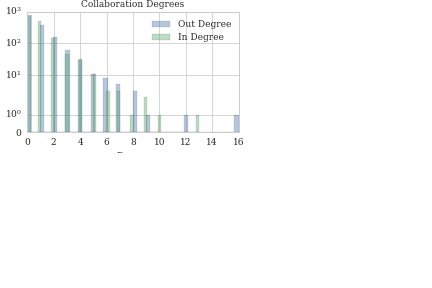

Out degree:                  0
count  1462.000000
mean      0.830369
std       1.315919
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      16.000000 0    0.0
dtype: float64
In degree:                  0
count  1462.000000
mean      0.830369
std       1.179894
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max      13.000000 0    1.0
dtype: float64


In [20]:
#ax.set_xscale('log') #, basex=2)
#ax.set_yscale('log')

fig = plt.figure()
ax1 = sns.distplot(out_degree_sequence, kde=False, label='Out Degree')

ax1 = sns.distplot(in_degree_sequence, kde=False, label='In Degree')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Number of Channel')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Collaboration Degrees')

save_plot('collab_in_out_degrees.pdf', fig, s_width, s_height)

print 'Out degree:', pa.DataFrame(out_degree_sequence).describe(), pa.DataFrame(out_degree_sequence).median()
print 'In degree:', pa.DataFrame(in_degree_sequence).describe(), pa.DataFrame(in_degree_sequence).median()

#fig.set_size_inches(width, height)
#fig = plt.figure()
#ax2 = sns.distplot(degree_sequence, hist=False, label='Sum Degree')
#ax22 = sns.distplot(out_degree_sequence, hist=False, label='Out Degree')
#ax23 = sns.distplot(in_degree_sequence, hist=False, label='In Degree')
#ax23.legend()

#fig = plt.figure()
#ax3 = sns.distplot(degree_sequence)

In [132]:
# actual collabs list, edges list

def func(graph):
    data = []

    for e in graph.edges(data=True):
        item = {}
        item['from'] = e[0]
        item['to'] = e[1]
        item['cluster'] = e[2]['cluster']
        item['weight'] = e[2]['weight']
        if isinstance(e[2]['videos'], list):
            item['videos'] = e[2]['videos']
        else:
           item['videos'] = [e[2]['videos']]
        
        item['from_network'] = graph.node[e[0]]['network']
        if isinstance(graph.node[e[0]]['cluster'], list):
            item['from_cluster'] = graph.node[e[0]]['cluster'] 
        else:
            item['from_cluster'] = [graph.node[e[0]]['cluster']]

        item['from_popularity'] = df_channel.ix[e[0]].popularity
        item['from_category'] = df_channel.ix[e[0]].category
        item['from_topic'] =  df_channel.ix[e[0]].topicIds

        item['to_network'] = graph.node[e[1]]['network']
        if isinstance(graph.node[e[0]]['cluster'], list):
            item['to_cluster'] = graph.node[e[1]]['cluster'] 
        else:
            item['to_cluster'] = [graph.node[e[1]]['cluster']]
            
        item['to_popularity'] = df_channel.ix[e[1]].popularity
        item['to_category'] = df_channel.ix[e[1]].category
        item['to_topic'] = df_channel.ix[e[1]].topicIds
        
        # get list of video ids with collabs somehow here
        data.append(item)

    
    return data


df_graph = pa.DataFrame(func(G))
df_graph.loc[df_graph['from_network'] == 'Maker_Studios', 'from_network'] = 'Maker Studios'
df_graph.loc[df_graph['to_network'] == 'Maker_Studios', 'to_network'] = 'Maker Studios'

df_graph['from_cluster'] = df_graph['from_cluster'].apply(json.dumps)
df_graph['to_cluster'] = df_graph['to_cluster'].apply(json.dumps)
df_graph['videos'] = df_graph['videos'].apply(json.dumps)
df_graph.to_csv(DIR+r'/df_collabs.txt', sep=str('\t'), encoding='utf-8')



df_graph_filtered = pa.DataFrame(func(Gf))
df_graph_filtered.loc[df_graph_filtered['from_network'] == 'Maker_Studios', 'from_network'] = 'Maker Studios'
df_graph_filtered.loc[df_graph_filtered['to_network'] == 'Maker_Studios', 'to_network'] = 'Maker Studios'


df_graph_filtered['from_cluster'] = df_graph_filtered['from_cluster'].apply(json.dumps)
df_graph_filtered['to_cluster'] = df_graph_filtered['to_cluster'].apply(json.dumps)
df_graph_filtered['videos'] = df_graph_filtered['videos'].apply(json.dumps)
df_graph_filtered.to_csv(DIR+r'/df_filtered_collabs.txt', sep=str('\t'), encoding='utf-8')


print len(df_graph)
print len(df_graph_filtered)

df_graph_filtered.head()


#df_graph_filtered[df_graph_filtered.to == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']


1269
1214


,cluster,from,from_category,from_cluster,from_network,from_popularity,from_topic,to,to_category,to_cluster,to_network,to_popularity,to_topic,videos,weight
0,3521,UCZApDB9BW7ZjNcPb3Wu7rRg,Entertainment,"[""2018"", ""2707"", ""3204"", ""3205"", ""3521""]",None,3,Food,UC5evWLowv059QIovMFlKKBA,Music,"""""",1l1lv2tvbn7LsHWoygrwgA,3,Music,"[""Y4x2dAXup3U""]",1
1,3521,UCZApDB9BW7ZjNcPb3Wu7rRg,Entertainment,"[""2018"", ""2707"", ""3204"", ""3205"", ""3521""]",None,3,Food,UC4WjlJxCPSbykB0P3R1My1Q,Sports,"[""101"", ""387"", ""2368"", ""2957"", ""3128"", ""3129"",...",None,2,Sports,"[""FFMLvYw9CK4"", ""HWGFUWANtvQ""]",2
2,3678,UCGrs4qEyhPEavGBHNdDi26A,Entertainment,"[""3678""]",BroadbandTV,3,Action game,UC7IJcslj7NPvo12tyO5Qguw,People & Blogs,"[""""]",BroadbandTV,3,Movies,"[""1pUSd8MInd4"", ""M668-FpmXgc"", ""fQK9Sx6rk-c"", ...",5
3,2626,UC9Q0dAjbhv0FbwvoHRSmjxA,How-to & Style,"[""1478"", ""2626"", ""2649""]",Maker Studios,4,Hobby,UCY26xU0-avwTJ6F6TzUZVEw,Film & Animation,"[""877"", ""1001"", ""1047"", ""2483"", ""2816""]",DreamWorksTV,4,Movies,"[""DdUV2Yh53Ws""]",1
4,3674,UCLFTOcssnu2LGS3FxGA5tsQ,Entertainment,"[""3674"", ""3695""]",None,3,Hobby,UC7Rrbm84x8RK0OkKlHpmiUQ,Entertainment,"[""3540"", ""3689"", ""3773""]",BroadbandTV,4,Hobby,"[""dB50g5a1Dx8"", ""vl5VxPhX2LA""]",2


In [159]:
df_graph_filtered[df_graph_filtered['from'] == 'UC2FfW6_YHXUSfsndM2R37cQ']

df_graph_filtered[df_graph_filtered['from'] == 'UC45zwHCRNT5jA8sC5DUW7oQ']



,cluster,from,from_category,from_cluster,from_network,from_popularity,from_topic,to,to_category,to_cluster,to_network,to_popularity,to_topic,videos,weight
796,979,UC45zwHCRNT5jA8sC5DUW7oQ,Comedy,"[""979""]",Fullscreen,3,Lifestyle,UC2FfW6_YHXUSfsndM2R37cQ,Entertainment,"[""1056""]",None,3,Music of Latin America,"[""F76ntKET30k""]",1
797,979,UC45zwHCRNT5jA8sC5DUW7oQ,Comedy,"[""979""]",Fullscreen,3,Lifestyle,UCW-NL7CT8lQcJz843AAwtZQ,Entertainment,"[""2399""]",Fullscreen,3,Music,"[""Z9xT4Lw4YvQ"", ""_80emZkgKpI""]",2


In [ ]:
# Statistics about collabs (per channel pair (edges))
# counting collabs between channel, channel can have multiple collabs with different channel etc.

print 'Number of collaborations complete:', df_graph['weight'].sum()
print 'Number of collaborations complete, filtered:', df_graph_filtered['weight'].sum()


print 'Collaborations between channels:', df_graph['weight'].describe()
print 'Collaborations between channels, filtered:', df_graph_filtered['weight'].describe()

print 'Median number of collaborations between channels:', df_graph['weight'].median()
print 'Median number of collaborations between channels, filtered:', df_graph_filtered['weight'].median()


# Number of collaborations per channel pair

fig = plt.figure()
#ax1 = sns.distplot(df_graph['weight'], kde=False)
ax1 = sns.distplot(df_graph_filtered['weight'], kde=False)
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Channel Pairs')
#ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
plt.title('Number of Collaborations per Channel Pair')
save_plot('collab_channel_pairs.pdf', fig, s_width, s_height)
#fig = plt.figure()
#ax2 = sns.distplot(df_graph['weight'], hist=False)
#ax21 = sns.distplot(df_graph_filtered['weight'], hist=False, )


fig = plt.figure()
ax = sns.barplot(data=df_graph_filtered['weight'], ci=99, errwidth=1., capsize=.05)
plt.legend(["{}% CI".format(99)])
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('mean(Collaborations)')
plt.title('Number of Collaborations per Channel Pair')
ax.set_ylim(0.0, 4.0)
for bar in ax.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.
    newwidth = width/2
    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)

save_plot('collab_channel_pairs_bar_box.pdf', fig, s_width, s_height)

In [134]:
top_pairs = df_graph_filtered.sort_values(by=['weight'], ascending=False)[:10]


def get_name(id):
    with db._session_scope(False) as session:
        return session.query(Channel.title).filter(Channel.id == id).first()[0]
    
top_pairs['from'] = top_pairs['from'].apply(get_name)
top_pairs['to'] = top_pairs['to'].apply(get_name)

top_pairs.to_csv(DIR+r'/df_most_collabs_top_pairs.txt', sep=str('\t'), encoding='utf-8')

top_pairs

,cluster,from,from_category,from_cluster,from_network,from_popularity,from_topic,to,to_category,to_cluster,to_network,to_popularity,to_topic,videos,weight
422,2453,LegitLooksForLife,How-to & Style,"[""2453""]",Studio71,3,Fashion,LegitLifestyle,People & Blogs,"[""1117""]",None,2,Lifestyle,"[""-1SfMREnBIs"", ""0bCPVxRyEDQ"", ""0u0mISqGzfE"", ...",38
642,2754,MatthewSantoro 2,People & Blogs,"[""2754""]",Studio71,3,Lifestyle,MatthewSantoro,Education,"[""""]",Studio71,4,Lifestyle,"[""2b7iAFLAl3E"", ""4sOAdNEVLRU"", ""6uLk6wmHj_Q"", ...",36
866,1179,LandonProduction Vlogs,People & Blogs,"[""1179"", ""1180"", ""1325""]",None,2,Lifestyle,MostAmazingTop10,Education,"[""2060"", ""2811""]",BroadbandTV,4,Lifestyle,"[""0skRikrf1iY"", ""4SwrS5Wn3yc"", ""6IiJGRbDN1I"", ...",34
1180,2260,Nikol CrazyFamily,People & Blogs,"[""84"", ""2260""]",BroadbandTV,3,Hobby,Я - Alisa,People & Blogs,"""3514""",AIR,3,Hobby,"[""-Ut77i_IC5I"", ""1OSuO_pla_c"", ""47BSp9fuKVc"", ...",30
407,2997,Good Mythical MORE,Entertainment,"[""489"", ""2531"", ""2997"", ""3759""]",Studio71,4,Music,Good Mythical Morning,Entertainment,"[""1144"", ""1560"", ""2878"", ""3699""]",Studio71,5,Music,"[""2U_V89T5JEw"", ""2_hYfClYvxg"", ""CNz3f6uADbA"", ...",30
309,3699,Good Mythical Morning,Entertainment,"[""1144"", ""1560"", ""2878"", ""3699""]",Studio71,5,Music,Good Mythical MORE,Entertainment,"[""489"", ""2531"", ""2997"", ""3759""]",Studio71,4,Music,"[""-lctE_6tf8s"", ""4G6gAdU3zeg"", ""5iuTtnRETek"", ...",25
318,3354,JustKiddingNews,News & Politics,"[""1411"", ""1604"", ""3033"", ""3194"", ""3354"", ""3643""]",Studio71,4,Lifestyle,Bart & Geo,People & Blogs,"""2536""",Studio71,3,Lifestyle,"[""5PY94baTVAQ"", ""AhCnetfrAyA"", ""Cdgettu0biI"", ...",22
857,3298,Penteados para meninas,Entertainment,"[""1552"", ""3298""]",BroadbandTV,4,Lifestyle,Bel para meninas,Entertainment,"""""",BroadbandTV,4,Hobby,"[""1OGC6BDZp2g"", ""3z7gEPCYhKc"", ""4mwo0GtGd2w"", ...",21
867,1179,LandonProduction Vlogs,People & Blogs,"[""1179"", ""1180"", ""1325""]",None,2,Lifestyle,LandonProduction,Entertainment,"""2242""",BroadbandTV,3,Lifestyle,"[""4eDdHuojbdg"", ""55_iKfVE1rw"", ""6xAydhmxn3U"", ...",21
114,2537,Ashley & Nate,People & Blogs,"[""2102"", ""2537""]",None,3,Lifestyle,NatesLife,Comedy,"""""",Studio71,3,Entertainment,"[""4kkoI9soDPQ"", ""5ZURNK7tsCM"", ""7Ahlu9vKVFA"", ...",21


<IPython.core.display.Javascript object>


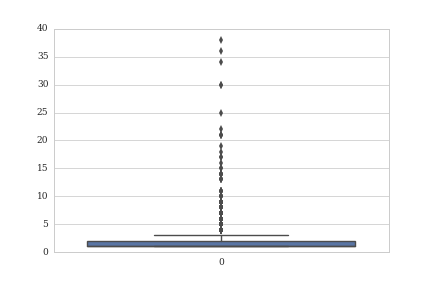

<IPython.core.display.Javascript object>


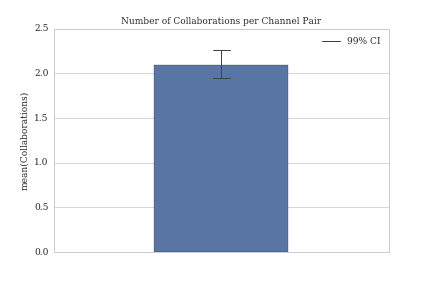

In [24]:
fig = plt.figure()
ax = sns.boxplot(data=df_graph_filtered['weight'])

fig = plt.figure()
ax = sns.barplot(data=df_graph_filtered['weight'], ci=90, errwidth=1., capsize=.05)
plt.legend(["{}% CI".format(99)])
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('mean(Collaborations)')
plt.title('Number of Collaborations per Channel Pair')
for bar in ax.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.
    newwidth = width/2
    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)

                          in_weight  out_weight  sum_weight
channel                                                    
UClpEE-Led9ZK0GJQKvU--3Q        0.0         0.0         0.0
UCZApDB9BW7ZjNcPb3Wu7rRg        3.0         3.0         6.0
UCMDz09-3zO1hm1pqRA-Er0A        2.0         0.0         2.0
UCGrs4qEyhPEavGBHNdDi26A        0.0         5.0         5.0
UCyTIAkFGK_oF59qJEnOB9GQ        0.0         0.0         0.0


<IPython.core.display.Javascript object>


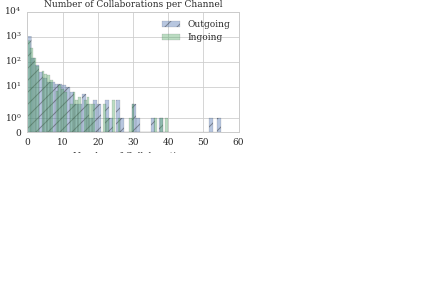

<IPython.core.display.Javascript object>


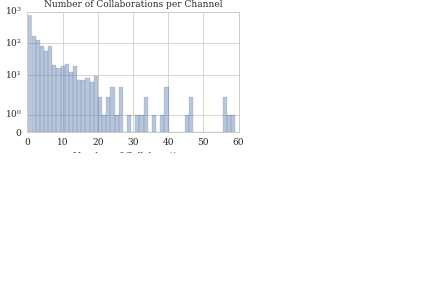

count    1462.000000
mean        3.480164
std         6.183866
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        59.000000
Name: sum_weight, dtype: float64


<IPython.core.display.Javascript object>


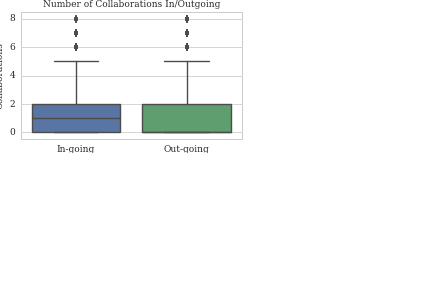

count    1462.000000
mean        1.740082
std         3.739391
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        40.000000
Name: in_weight, dtype: float64
count    1462.000000
mean        1.740082
std         4.220743
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        55.000000
Name: out_weight, dtype: float64


<IPython.core.display.Javascript object>


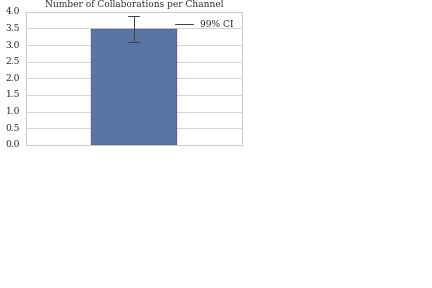

In [25]:
# Statistics about channel and their overall collabs (channel wise)
# counting in and outgoing overall collabs per channel (every channel has single value)

# trenne out and ingoing?
# sum ingoing weights of every node in the graph -> in, out going weight -> overall collabs

df_channel_collab_weights = pa.DataFrame(G.nodes(),columns=['channel']) # use all channel list not only from collab graph?
df_channel_collab_weights = df_channel_collab_weights.set_index(['channel'])

df_channel_collab_weights_filtered = pa.DataFrame(Gf.nodes(),columns=['channel'])
df_channel_collab_weights_filtered = df_channel_collab_weights_filtered.set_index(['channel'])

df_channel_collab_weights_filtered['in_weight'] = np.nan
df_channel_collab_weights_filtered['out_weight'] = np.nan
df_channel_collab_weights_filtered['sum_weight'] = np.nan

for node in Gf.nodes():
    outs = Gf.out_edges(node)
    out_weight = 0
    for e in outs:
        out_weight += Gf.get_edge_data(e[0], e[1])['weight']

    ins = Gf.in_edges(node)
    in_weight = 0
    for e in ins:
        in_weight += Gf.get_edge_data(e[0], e[1])['weight']

    df_channel_collab_weights_filtered.loc[node, 'in_weight'] = in_weight
    df_channel_collab_weights_filtered.loc[node, 'out_weight'] = out_weight
    df_channel_collab_weights_filtered.loc[node, 'sum_weight'] = in_weight+out_weight
    

print df_channel_collab_weights_filtered.head()

fig = plt.figure()
ax1 = sns.distplot(df_channel_collab_weights_filtered['out_weight'], kde=False, label='Outgoing')

# Define some hatches
hatches = ['-', '+', 'x', '\\', '*', 'o']

# Loop over the bars
for i,thisbar in enumerate(ax1.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch('//')
    
ax1 = sns.distplot(df_channel_collab_weights_filtered['in_weight'], kde=False, label='Ingoing')
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Channel')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Number of Collaborations per Channel')
save_plot('collab_in_out_collabs.pdf', fig, s_width, s_height)

fig = plt.figure()
ax1 = sns.distplot(df_channel_collab_weights_filtered['sum_weight'], kde=False)
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Channel')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Number of Collaborations per Channel')
save_plot('collab_nof_collabs_per_channel.pdf', fig, s_width, s_height)

print df_channel_collab_weights_filtered['sum_weight'].describe()

df_test_weights = []
for i, row in df_channel_collab_weights_filtered.iterrows():
    df_test_weights.append((row['in_weight'], 'in_weight'))
    df_test_weights.append((row['out_weight'], 'out_weight'))
df_test_weights = pa.DataFrame(df_test_weights, columns=['weight', 'direction'])
df_test_weights.head()



fig = plt.figure()
ax = sns.boxplot(x='direction', y='weight', data=df_test_weights)
print df_channel_collab_weights_filtered['in_weight'].describe()
print df_channel_collab_weights_filtered['out_weight'].describe()

ax.set_xticklabels(['In-going', 'Out-going'])
ax.set_ylabel('Collaborations')
ax.set_xlabel('')
plt.title('Number of Collaborations In/Outgoing')
ax.set_ylim([-0.5, 8.5])
save_plot('collab_in_out_collabs_box.pdf', fig, s_width, s_height)


fig = plt.figure()
ax = sns.barplot(data=df_channel_collab_weights_filtered['sum_weight'], ci=99, errwidth=1., capsize=.05)
plt.legend(["{}% CI".format(99)])
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('mean(Collaborations)')
plt.title('Number of Collaborations per Channel')

for bar in ax.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.
    newwidth = width/2
    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)

save_plot('collab_nof_collabs_per_channel_bar_box.pdf', fig, s_width, s_height)

In [135]:
sorted_collabs =  df_channel_collab_weights_filtered['sum_weight'].sort_values(ascending=False)

sorted_collabs = sorted_collabs[:10]
print sorted_collabs
#most_collabs = pa.DataFrame(['channel0', 'channel1', 'nof'])
most_collabs = []

for index1, sumw in sorted_collabs.iteritems():
    #print index1, sumw
    froms = df_graph_filtered[df_graph_filtered['from'] == index1][['to', 'weight', 'cluster']]
    tos = df_graph_filtered[df_graph_filtered.to == index1][['from', 'weight', 'cluster']]
    
    for index2, row in froms.iterrows():
        most_collabs.append( (index1, sumw,  row['to'], row['weight'], row['cluster']) )
    
    for index2, row in tos.iterrows():
        most_collabs.append( (index1, sumw, row['from'], row['weight'], row['cluster']) )
    
most_collabs = pa.DataFrame(most_collabs)

#most_collabs.set_index([0, 1], inplace=True)

#most_collabs = most_collabs.reset_index()


def get_name(id):
    with db._session_scope(False) as session:
        return session.query(Channel.title).filter(Channel.id == id).first()[0]
    
most_collabs[0] = most_collabs[0].apply(get_name)
most_collabs[2] = most_collabs[2].apply(get_name)


most_collabs.columns = ['channel0', 'total', 'channel1', 'count', 'cluster']

most_collabs.set_index(['channel0', 'total', ], inplace=True)

most_collabs.to_csv(DIR+r'/df_most_collabs_top.txt', sep=str('\t'), encoding='utf-8')

most_collabs


channel
UCoKGanMmrKj8RAqAwS5vRug    59.0
UCfPhyExfcaqJBKc3HO3cNBw    57.0
UCzpCc5n9hqiVC7HhPwcIKEg    56.0
UC4PooiX37Pld1T8J5SYT-SQ    56.0
UCBINYCmwE29fBXCpUI8DgTA    47.0
UC_DVkYrg5uDDEjLHx4bStig    47.0
UCVbPnm-qCjH-8Yl1-k4BQkA    46.0
UCsr4lPNPq2GZ76ocdNMAArA    40.0
UCXKYhP9a5-zljG_zaC7UBaQ    40.0
UCs-RHLMgqjC1CS9Rsq4I3Xg    40.0
Name: sum_weight, dtype: float64


channel1  count cluster
channel0               total                                       
LandonProduction Vlogs 59.0         MostAmazingTop10     34    1179
                       59.0         LandonProduction     21    1179
                       59.0           InformOverload      1    2409
                       59.0         MostAmazingTop10      2    2811
                       59.0         LandonProduction      1    2242
JustKiddingNews        57.0         JustKiddingFilms      9    3354
                       57.0                   Joe Jo      1    3194
                       57.0            James Rodolfo      8    3643
                       57.0               Bart & Geo     22    3354
                       57.0         JustKiddingParty      9    3354
                       57.0          Barbell Brigade      3    3354
                       57.0               Nikki Limo      1    1075
                       57.0         JustKiddingParty      2    1277
                       57.0           Joseph Germani      2    1650
Good Mythical MORE     56.0    Good Mythical Morning     30    2997
                       56.0    Good Mythical Morning     25    3699
                       56.0         MostAmazingTop10      1    2811
Good Mythical Morning  56.0              schmoesknow      1    3699
                       56.0       Good Mythical MORE     25    3699
                       56.0       Good Mythical MORE     30    2997
MostAmazingTop10       47.0   LandonProduction Vlogs      2    2811
                       47.0           InformOverload      3    2811
                       47.0       Good Mythical MORE      1    2811
                       47.0                iO Trendz      1    2060
                       47.0        Terra Estrangeira      1    2861
                       47.0             vagabrothers      1    1168
                       47.0                PewDiePie      1    1581
                       47.0                      CBR      1     175
                       47.0      Music Covers Brasil      1    2526
                       47.0   LandonProduction Vlogs     34    1179
                       47.0           Pranks Network      1    1467
Nikol CrazyFamily      47.0                Я - Alisa     30    2260
                       47.0                Я - Alisa     16    3514
                       47.0            The Piano Gal      1    2947
Я - Alisa              46.0        Nikol CrazyFamily     16    3514
                       46.0        Nikol CrazyFamily     30    2260
MatthewSantoro 2       40.0           MatthewSantoro     36    2754
                       40.0             vagabrothers      1    1168
                       40.0                 Rob Dyke      2    2300
                       40.0                 Undoomed      1     245
LegitLifestyle         40.0        LegitLooksForLife      2    1117
                       40.0        LegitLooksForLife     38    2453
LegitLooksForLife      40.0           LegitLifestyle     38    2453
                       40.0           LegitLifestyle      2    1117

In [136]:
# number of collabs/ Number of videos ratio

# number of collabs -> channel weights (count only in-edges? because in-edges are own videos, 
# out would include videos from othe channel)
# number of videos -> DB, other DF

df_channel_collab_weights_filtered['video/collab ratio'] = np.nan
df_channel_collab_weights_filtered.loc[:, 'nof_videos'] = np.nan

for node in Gf.nodes():
    in_weight = df_channel_collab_weights_filtered.loc[node, 'in_weight']
    with db._session_scope(False) as session:
        nof_videos = session.query(Video.id).filter(Video.channelID == node).count()
    df_channel_collab_weights_filtered.loc[node, 'nof_videos'] = nof_videos
    #print nof_videos, in_weight, in_weight/nof_videos
    df_channel_collab_weights_filtered.loc[node, 'video/collab ratio'] = in_weight / nof_videos

    
#print df_channel_collab_weights[['in_weight', 'out_weight', 'nof_videos', 'video/collab ratio']].sort_values(by='video/collab ratio', ascending=False)

<IPython.core.display.Javascript object>


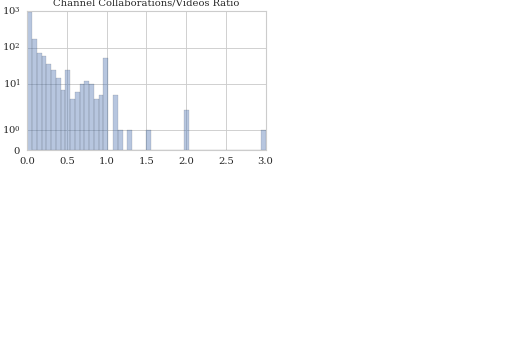

count    1462.000000
mean        0.130726
std         0.268279
min         0.000000
25%         0.000000
50%         0.016393
75%         0.111111
max         3.000000
Name: video/collab ratio, dtype: float64

In [137]:
#number of collabs/ Number of videos ratio

fig = plt.figure()
ax1 = sns.distplot(df_channel_collab_weights_filtered['video/collab ratio'], kde=False)
ax1.set_xlabel('Collaboration/Video Ratio')
ax1.set_ylabel('Channel')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Channel Collaborations/Videos Ratio')

save_plot('collab_video_ratios.pdf', fig, s_width, s_height)

#fig = plt.figure()
#ax2 = sns.distplot(df_channel_collab_weights_filtered['video/collab ratio'], hist=False)
#ax2.set_yscale('log')
#ax2.set_xscale('log')

df_channel_collab_weights_filtered['video/collab ratio'].describe()

In [138]:
# assigns network and popularity in channel list df_channel_collab_weights_filtered


df_channel_collab_weights_filtered['network'] = np.nan
df_channel_collab_weights_filtered['popularity'] = np.nan

for index, row in df_channel_collab_weights_filtered.iterrows():
    df_channel_collab_weights_filtered.loc[index, 'network'] = df_channel.loc[index, 'network']
    df_channel_collab_weights_filtered.loc[index, 'popularity'] = df_channel.loc[index, 'popularity']


# Collabs by network
# number of collabs complete (all channels) per network, dist.
networks = []
for name, group in df_channel_collab_weights_filtered.groupby(['network']):
    #print name, group['sum_weight'].sum()
    networks.append((name, group['in_weight'].sum(), group['out_weight'].sum()))
df_network_collabs = pa.DataFrame(networks, columns=['network', 'in_collabs', 'out_collabs'])
df_network_collabs = df_network_collabs.set_index(['network'])

# number of collabs by popularity, per popularity class -> in or outgoing collabs? both?
popularitys = []
for name, group in df_channel_collab_weights_filtered.groupby(['popularity']):
    #print name, group['sum_weight'].sum()
    popularitys.append((name, group['in_weight'].sum(), group['out_weight'].sum()))
df_popularitys_collabs = pa.DataFrame(popularitys, columns=['popularity', 'in_collabs', 'out_collabs'])
df_popularitys_collabs = df_popularitys_collabs.set_index(['popularity'])

print df_network_collabs.head()
print df_popularitys_collabs.head()
# Number of collabs between channel in their own network, and collabs over networks

                        in_collabs  out_collabs
network                                        
1l1lv2tvbn7LsHWoygrwgA         1.0          0.0
2btube                         2.0          0.0
AGE Network                    0.0          0.0
AIR                           31.0         16.0
ARD JungesAngebot              1.0          0.0
            in_collabs  out_collabs
popularity                         
0.0               46.0         16.0
1.0               83.0         85.0
2.0              496.0        440.0
3.0             1202.0       1357.0
4.0              669.0        590.0


<IPython.core.display.Javascript object>


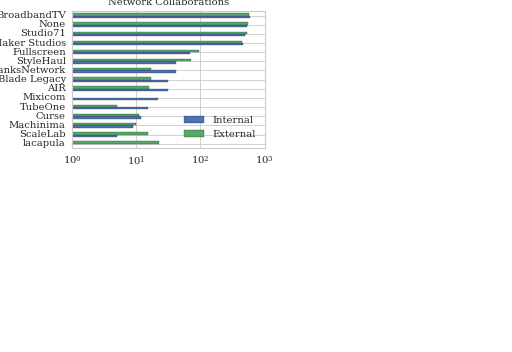

<IPython.core.display.Javascript object>


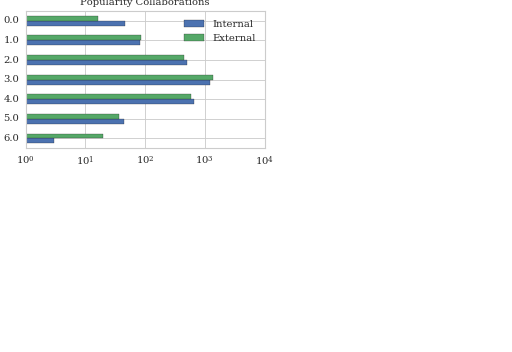

In [139]:
fig, axes = plt.subplots()
ax = df_network_collabs[ (df_network_collabs.in_collabs+df_network_collabs.out_collabs) > 18].sort_values(by=['in_collabs', 'out_collabs'], ascending=True).plot(ax=axes, kind='barh')
ax.set_xlabel('Number of Collaborations')
ax.set_ylabel('Network')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend(loc=0, labels=['Internal', 'External'])
plt.title('Network Collaborations')
plt.tight_layout()
save_plot('collab_in_out_networks.pdf', fig, s_width, s_height)

fig, axes = plt.subplots()
ax1 = df_popularitys_collabs.sort_index(ascending=False).plot(ax=axes,kind='barh')
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Popularity')
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.legend(loc=0, labels=['Internal', 'External'])
plt.title('Popularity Collaborations')
plt.tight_layout()
save_plot('collab_in_out_popularity.pdf', fig, s_width, s_height)

[[   0.    1.    6.    6.    2.    0.    0.]
 [   2.    4.   16.   30.    3.    0.    0.]
 [   9.   16.   61.   97.   40.    0.    0.]
 [   9.   27.  128.  311.  138.    2.    1.]
 [   1.    5.   54.  120.   95.    4.    2.]
 [   0.    0.    1.    3.    4.    0.    0.]
 [   0.    0.    4.    9.    3.    0.    0.]]


<IPython.core.display.Javascript object>


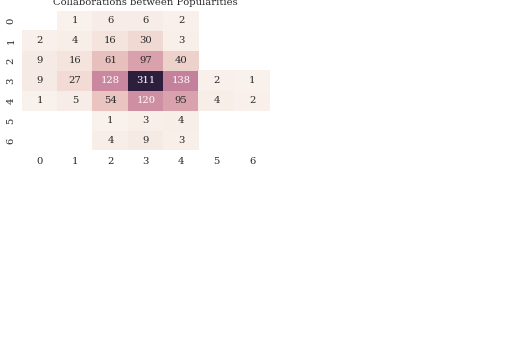

In [140]:
# Collabs between popularitys
pops = df_graph_filtered[['from_popularity', 'to_popularity']]
y = pops['from_popularity'].nunique()
x = pops['to_popularity'].nunique()
arr = np.zeros((y, x))

for row in pops.iterrows():
    #print row[0], row[1][0], row[1][1]
    arr[row[1][0], row[1][1]] += 1

print arr
# divide every arr field through the number of videos in this pair?
df_arr = pa.DataFrame(arr)

fig = plt.figure()
ax = sns.heatmap(df_arr, annot=True, fmt='g', cbar=False, mask=df_arr<=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
#ax.set_xscale('log')
#ax1.set_yscale('log')
plt.title('Collaborations between Popularities')
plt.tight_layout()
save_plot('collab_popularity_heatmap.pdf', fig, s_width, s_height)

[[   0.    1.    6.    6.    2.    0.    0.]
 [   2.    4.   16.   30.    3.    0.    0.]
 [   9.   16.   61.   97.   40.    0.    0.]
 [   9.   27.  128.  311.  138.    2.    1.]
 [   1.    5.   54.  120.   95.    4.    2.]
 [   0.    0.    1.    3.    4.    0.    0.]
 [   0.    0.    4.    9.    3.    0.    0.]]
[[     0.     30.     90.     90.     30.      0.      0.]
 [    30.    120.    525.    555.     45.      0.      0.]
 [   255.    390.   1605.   2925.   1425.      0.      0.]
 [   375.    630.   3900.  10425.   4920.     90.     15.]
 [    30.     75.   1215.   3825.   3090.    585.     30.]
 [     0.      0.     30.     45.    465.      0.      0.]
 [     0.      0.     75.    165.     60.      0.      0.]]
[[   0.           30.           15.           15.           15.            0.
     0.        ]
 [  15.           30.           32.8125       18.5          15.            0.
     0.        ]
 [  28.33333333   24.375        26.31147541   30.15463918   35.625         0.
  

<IPython.core.display.Javascript object>


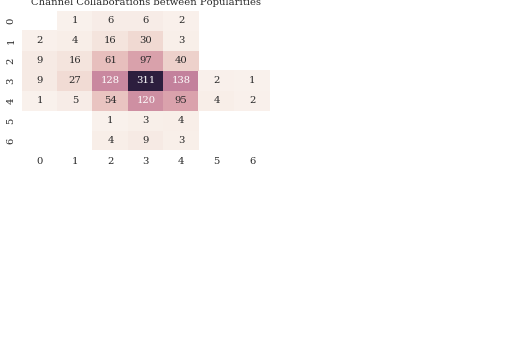

<IPython.core.display.Javascript object>


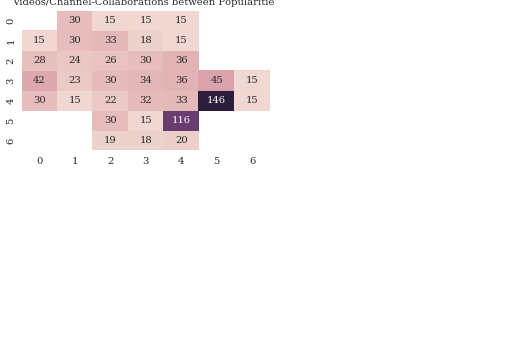

In [184]:
# Collabs between popularitys
pops = df_graph_filtered[['from_popularity', 'to_popularity', 'videos']]
y = pops['from_popularity'].nunique()
x = pops['to_popularity'].nunique()
#vids = pops['videos'].apply(len)

arr = np.zeros((y, x))
arr_div = np.zeros((y, x))

for row in pops.iterrows():
    #print row[0], row[1][0], row[1][1]
    arr[row[1][0], row[1][1]] += 1
    arr_div[row[1][0], row[1][1]] += len(row[1][2])

print arr


arr[arr == 0] = 0.0000001
arr_test = arr_div / arr

print arr_div

print arr_test
arr[arr == 0.0000001] = 0
# divide every arr field through the number of videos in this pair?
df_arr = pa.DataFrame(arr)

fig = plt.figure()
ax = sns.heatmap(df_arr, annot=True, fmt='g', cbar=False, mask=df_arr<=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
#ax.set_xscale('log')
#ax1.set_yscale('log')
plt.title('Channel Collaborations between Popularities')
plt.tight_layout()
save_plot('collab_popularity_heatmap.pdf', fig, s_width, s_height)


#scaler = MinMaxScaler(feature_range=(0, 1))
#arr_test = scaler.fit_transform(arr_test)
#print arr_test
df_arr = pa.DataFrame(arr_test)

fig = plt.figure()
ax = sns.heatmap(df_arr, annot=True, fmt='.0f', cbar=False, mask=df_arr<=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
#ax.set_xscale('log')
#ax1.set_yscale('log')
plt.title('Videos/Channel-Collaborations between Popularities')
plt.tight_layout()
save_plot('collab_popularity_heatmap_normalized_2.pdf', fig, s_width, s_height)

In [144]:
bins = [0, 1.0e+3, 1.0e+4, 1.0e+5, 1.0e+6, 1.0e+7, 5.0e+7, 1.0e+8]
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)


for i, (a, b) in enumerate(pairwise(bins)):
    print i,':', a, b

0 : 0 1000.0
1 : 1000.0 10000.0
2 : 10000.0 100000.0
3 : 100000.0 1000000.0
4 : 1000000.0 10000000.0
5 : 10000000.0 50000000.0
6 : 50000000.0 100000000.0


<IPython.core.display.Javascript object>


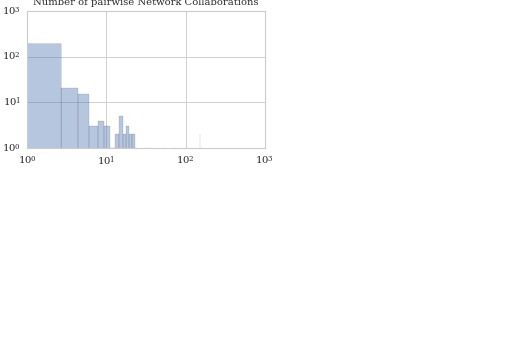

270
32


In [145]:
# network collabs
    
network_pairs = []
for name, group in df_graph_filtered.groupby(['from_network', 'to_network']):
    network_pairs.append((name[0], name[1], group['weight'].sum()))
    
df_network_pairs_collabs = pa.DataFrame(network_pairs, columns=['from_network','to_network', 'nof_collabs'])

#df_network_pairs_collabs.plot()

fig = plt.figure()
ax = sns.distplot(df_network_pairs_collabs['nof_collabs'], kde=False, bins=200)
ax.set_xlabel('Number of Collaborations')
ax.set_ylabel('Network Pairs')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Number of pairwise Network Collaborations')
plt.tight_layout()

save_plot('collab_network_pairs.pdf', fig, s_width, s_height)

#print df_network_pairs_collabs.sort_values(by='nof_collabs', ascending=False).head()
print len(df_network_pairs_collabs)

df_network_collabs_mask = df_network_pairs_collabs[df_network_pairs_collabs.nof_collabs > 10]
#print df_network_collabs_mask.sort_values(by='nof_collabs', ascending=False).head()
print len(df_network_collabs_mask)



                             nof_collabs
from_network  to_network                
Studio71      Studio71               338
BroadbandTV   BroadbandTV            291
Maker Studios Maker Studios          275
None          None                   159
BroadbandTV   None                   152
872
10
11
872 872 872
10 [u'AIR' u'BroadbandTV' u'Fullscreen' 'Maker Studios' u'None'
 u'PranksNetwork' u'ScaleLab' u'Studio71' u'StyleHaul' u'lacapula']
11 [u'AIR' u'BroadbandTV' u'Fullscreen' 'Maker Studios' u'Mixicom' u'None'
 u'PranksNetwork' u'Social Blade Legacy' u'Studio71' u'StyleHaul'
 u'TubeOne']
(11, 10)


<IPython.core.display.Javascript object>


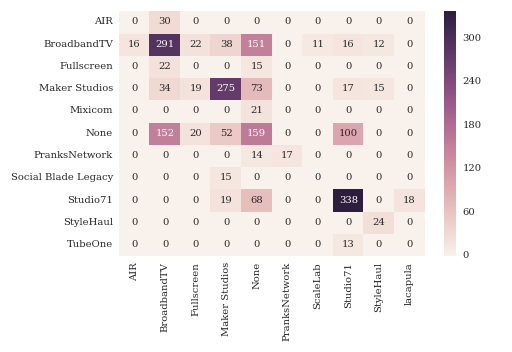

<IPython.core.display.Javascript object>


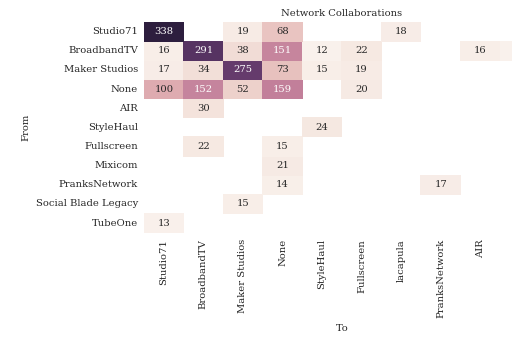

<IPython.core.display.Javascript object>


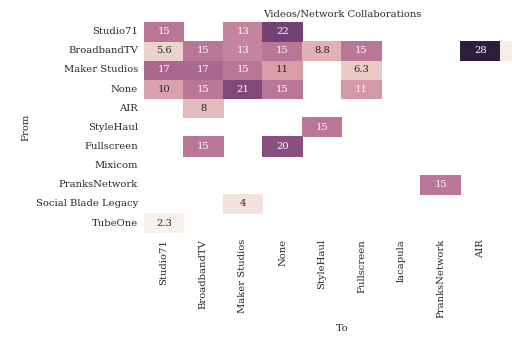

In [186]:
# Collabs between networks

def f(x1, x2):
    return ((df_network_collabs_mask['from_network'] == x1) & (df_network_collabs_mask['to_network'] == x2)).any()

df_graph_collabs_vis = df_graph_filtered[df_graph_filtered[['from_network','to_network']].apply(lambda x: f(*x), axis=1)]


network_test = []
for name, group in df_graph_collabs_vis.groupby(['from_network', 'to_network']):
    network_test.append((name[0], name[1], group['weight'].sum()))

    
df_network_test_collabs = pa.DataFrame(network_test, columns=['from_network','to_network', 'nof_collabs'])
df_network_test_collabs = df_network_test_collabs.set_index(['from_network', 'to_network'])
df_network_test_collabs = df_network_test_collabs.sort_values(by='nof_collabs', ascending=False)

def unique(array):
    uniq, index = np.unique(array, return_index=True)
    return uniq[index.argsort()]

print df_network_test_collabs.head()

#print df_graph_collabs_vis.head()
print len(df_graph_collabs_vis)
print df_graph_collabs_vis['from_network'].nunique()
print df_graph_collabs_vis['to_network'].nunique()

Xuniques, X = np.unique(df_graph_collabs_vis['from_network'], return_inverse=True)
Yuniques, Y = np.unique(df_graph_collabs_vis['to_network'], return_inverse=True)
Wuniques, W = np.unique(df_graph_collabs_vis['weight'], return_inverse=True)

print len(W), len(X),len(Y)
#fig = plt.figure()
#plt.scatter(X, Y, c=W)

nets = pa.DataFrame([Y, X, W]).T
nets.columns = ['from', 'to', 'weight']

print len(Xuniques), Xuniques #, X
print len(Yuniques), Yuniques #, Y

arrc = np.zeros((len(Yuniques), len(Xuniques)))
print arrc.shape

for row in nets.iterrows():
    #print row[0], row[1][0], row[1][1], row[1][2]
    arrc[row[1][0], row[1][1]] += Wuniques[row[1][2]]

#print arrc
fig = plt.figure()
ax = sns.heatmap(arrc, annot=True, yticklabels=Yuniques, xticklabels=Xuniques, fmt='g')

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
#ax.invert_yaxis()

fig.tight_layout()
#fig.subplots_adjust(bottom=0.2)

index_test = df_network_test_collabs.index.values
index_test1, index_test2 = zip(*index_test)

index_test1 = unique(index_test1)
index_test2 = unique(index_test2)

test = df_network_test_collabs.unstack(0)
test = test.reindex(index_test2)
#print test.index
new_test = []

for lvl in index_test1:
    vals = test[('nof_collabs', lvl)]

    new_test.append(vals)
    #new_test.append(test[('nof_collabs', lvl)])
new_test = pa.DataFrame(new_test).T

new_test_2 = new_test.copy()

for i, row in new_test_2.iterrows():
    for j, item in row.iteritems():
        v = 0
        for l in df_graph_filtered[(df_graph_filtered.from_network==i) & (df_graph_filtered.to_network==j[1])]['videos']:
            v += len(l)
        #print item, v
        if item and v:
            new_test_2.loc[(i, j)] = v/item #item/v
        else:
            new_test_2.loc[(i, j)] = np.nan
    
fig = plt.figure()
ax = sns.heatmap(new_test, annot=True, yticklabels=index_test2, xticklabels=index_test1, fmt='g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Network Collaborations')
plt.tight_layout()

save_plot('collab_network_heatmap.pdf', fig, x_width, x_height)


fig = plt.figure()
ax = sns.heatmap(new_test_2, annot=True, yticklabels=index_test2, xticklabels=index_test1, fmt='.2g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Videos/Network Collaborations')
plt.tight_layout()
save_plot('collab_network_heatmap_normalized_2.pdf', fig, x_width, x_height)

<IPython.core.display.Javascript object>


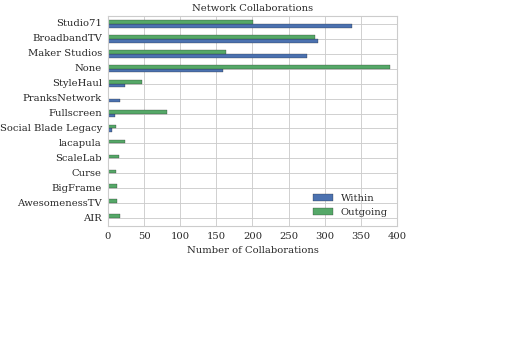

In [147]:
# Show the numbers of collabs in their own network in difference to outside of networks
# (from==to and from!=to)

in_out = []
test = df_network_pairs_collabs.groupby(by='from_network')
for name, group in test:
    #print name, ':'
    in_out.append( (name, group[group.to_network == name]['nof_collabs'].sum(), group[group.to_network != name]['nof_collabs'].sum()) )


df_collabs_in_out = pa.DataFrame(in_out, columns=['network', 'within', 'outreaching'])
df_collabs_in_out_vis = df_collabs_in_out[ (df_collabs_in_out.within+df_collabs_in_out.outreaching > 10)].sort_values(by='within', ascending=True)
ax = df_collabs_in_out_vis.plot(kind='barh')
ax.set_yticklabels(df_collabs_in_out_vis['network'].tolist())
ax.set_xlabel('Number of Collaborations')
ax.set_ylabel('Network')
ax.legend(loc=0, labels=['Within', 'Outgoing'])
plt.title('Network Collaborations')
plt.tight_layout()
save_plot('collab_network_within_out.pdf', ax.get_figure(), 1.5*s_width,  1.5*s_height)

number of collabs: 1214
Empty DataFrame
Columns: [cluster, from, from_category, from_cluster, from_network, from_popularity, from_topic, to, to_category, to_cluster, to_network, to_popularity, to_topic, videos, weight]
Index: []
Empty DataFrame
Columns: [cluster, from, from_category, from_cluster, from_network, from_popularity, from_topic, to, to_category, to_cluster, to_network, to_popularity, to_topic, videos, weight]
Index: []
15 [u'Cars & Vehicles' u'Comedy' u'Education' u'Entertainment'
 u'Film & Animation' u'Gaming' u'How-to & Style' u'Music'
 u'News & Politics' u'Non-profits & Activism' u'People & Blogs'
 u'Pets & Animals' u'Science & Technology' u'Sports' u'Travel & Events']
15 [u'Cars & Vehicles' u'Comedy' u'Education' u'Entertainment'
 u'Film & Animation' u'Gaming' u'How-to & Style' u'Music'
 u'News & Politics' u'Non-profits & Activism' u'People & Blogs'
 u'Pets & Animals' u'Science & Technology' u'Sports' u'Travel & Events']
(15, 15)


<IPython.core.display.Javascript object>


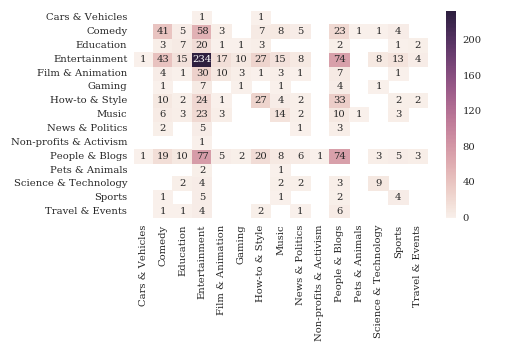

Entertainment ('nof_collabs', u'Entertainment') 234.0 7380
Entertainment ('nof_collabs', u'People & Blogs') 77.0 2625
Entertainment ('nof_collabs', u'Comedy') 58.0 825
Entertainment ('nof_collabs', u'How-to & Style') 24.0 510
Entertainment ('nof_collabs', u'Film & Animation') 30.0 270
Entertainment ('nof_collabs', u'Music') 23.0 225
Entertainment ('nof_collabs', u'Education') 20.0 465
Entertainment ('nof_collabs', u'Science & Technology') 4.0 165
Entertainment ('nof_collabs', u'Gaming') 7.0 210
Entertainment ('nof_collabs', u'Travel & Events') 4.0 60
Entertainment ('nof_collabs', u'Sports') 5.0 210
Entertainment ('nof_collabs', u'News & Politics') 5.0 135
Entertainment ('nof_collabs', u'Pets & Animals') 2.0 0
Entertainment ('nof_collabs', u'Cars & Vehicles') 1.0 15
Entertainment ('nof_collabs', u'Non-profits & Activism') 1.0 0
People & Blogs ('nof_collabs', u'Entertainment') 74.0 3210
People & Blogs ('nof_collabs', u'People & Blogs') 74.0 3180
People & Blogs ('nof_collabs', u'Comedy') 

<IPython.core.display.Javascript object>


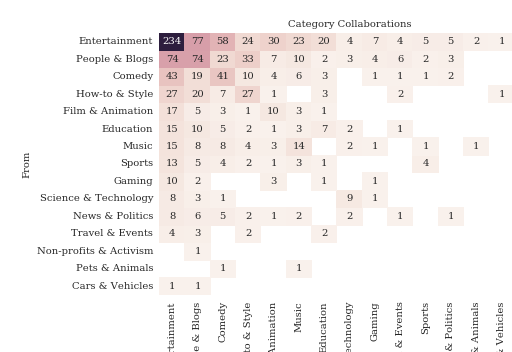

<IPython.core.display.Javascript object>


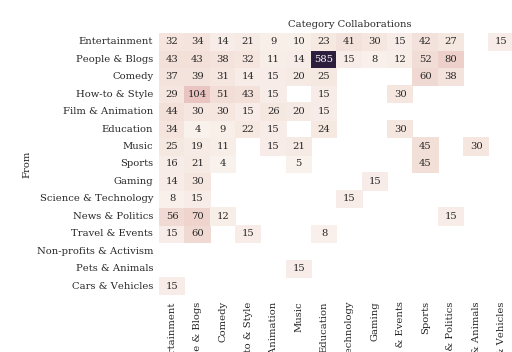

In [190]:
# Collabs between channel categories

print 'number of collabs:', len(df_graph_filtered)

print df_graph_filtered[df_graph_filtered.from_category.isnull()]
print df_graph_filtered[df_graph_filtered.to_category.isnull()]

Xuniques, X = np.unique(df_graph_filtered['from_category'], return_inverse=True)
Yuniques, Y = np.unique(df_graph_filtered['to_category'], return_inverse=True)

#cats = df_graph[['to_category', 'from_category']]
cats = pa.DataFrame([X, Y]).T
#print cats
print len(Xuniques), Xuniques #, X
print len(Yuniques), Yuniques #, Y

arrc = np.zeros((len(Yuniques), len(Xuniques)))

print arrc.shape

for row in cats.iterrows():
    #print row[0], row[1][0], row[1][1]
    arrc[row[1][0], row[1][1]] += 1

fig = plt.figure()
ax = sns.heatmap(arrc, annot=True, yticklabels=Yuniques, xticklabels=Xuniques, fmt='g', mask=arrc <= 0.0)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
#ax.invert_yaxis()
fig.tight_layout()
#fig.subplots_adjust(bottom=0.2)



cat_test = []
for name, group in df_graph_filtered.groupby(['from_category', 'to_category']):
    #print group.index
    cat_test.append((name[0], name[1], len(group)))

df_cat = pa.DataFrame(cat_test, columns=['from_category','to_category', 'nof_collabs'])
df_cat = df_cat.set_index(['from_category', 'to_category'])
df_cat = df_cat.sort_values(by='nof_collabs', ascending=False)

fig.tight_layout()
#fig.subplots_adjust(bottom=0.2)

index_test = df_cat.index.values
index_test1, index_test2 = zip(*index_test)

index_test1 = unique(index_test1)
index_test2 = unique(index_test2)

test = df_cat.unstack(0)
test = test.reindex(index_test2)

new_test = []
for lvl in index_test1:
    new_test.append(test[('nof_collabs', lvl)])
new_test = pa.DataFrame(new_test).T


new_test_2 = new_test.copy()

for i, row in new_test_2.iterrows():
    for j, item in row.iteritems():
        v = 0
        for l in df_graph_filtered[(df_graph_filtered.from_category==i) & (df_graph_filtered.to_category==j[1])]['videos']:
            v += len(l)
        #print i, j, item, v
        if item and v:
            new_test_2.loc[(i, j)] = v/item #item/v
        else:
            new_test_2.loc[(i, j)] = np.nan


fig = plt.figure()
ax = sns.heatmap(new_test, annot=True, yticklabels=index_test2, xticklabels=index_test1, fmt='g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Category Collaborations')
plt.tight_layout()
save_plot('collab_category_heatmap.pdf', fig, x_width, 1.5*x_height)


fig = plt.figure()
ax = sns.heatmap(new_test_2, annot=True, yticklabels=index_test2, xticklabels=index_test1, fmt='.0f', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Category Collaborations')
save_plot('collab_category_heatmap_normalized_2.pdf', fig, x_width, 1.5*x_height)

In [150]:
# prefiltered cluster analyse atm not interesting as proba and persistence of hdbscan is not very diverse
# because we only used the first 20 cluster instead of 100

df_collabs_prefiltered = pa.read_csv(DIR+r'/hdb_collab_prefiltered_cluster.txt', sep=str('\t'), encoding='utf-8')

df_collabs_prefiltered.head()

IOError: File ../../data/data_evaluation_2/hdb_collab_prefiltered_cluster.txt does not exist

<IPython.core.display.Javascript object>


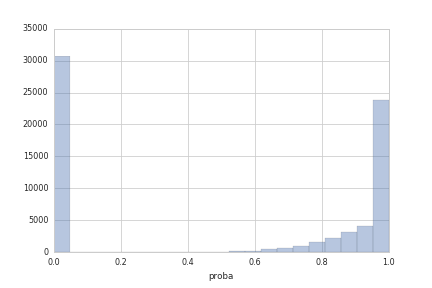

<IPython.core.display.Javascript object>


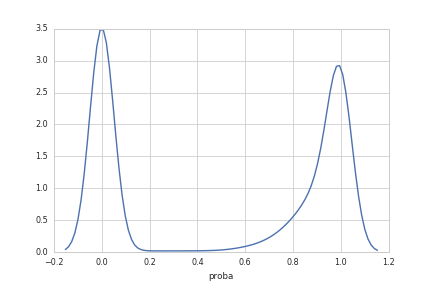

<IPython.core.display.Javascript object>


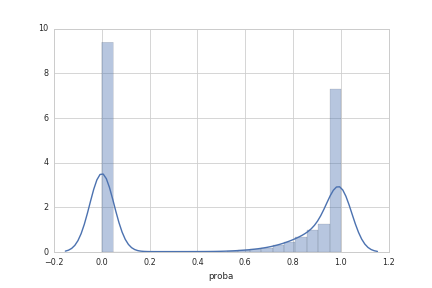

In [196]:
fig = plt.figure()
ax1 = sns.distplot(df_collabs_prefiltered['proba'], kde=False)

fig = plt.figure()
ax2 = sns.distplot(df_collabs_prefiltered['proba'], hist=False)

fig = plt.figure()
ax3 = sns.distplot(df_collabs_prefiltered['proba'])


<IPython.core.display.Javascript object>


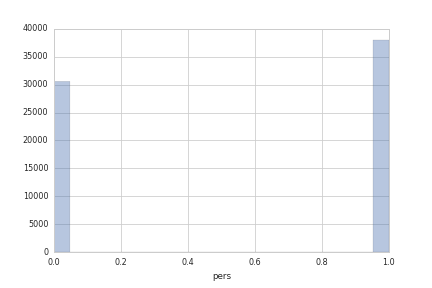

<IPython.core.display.Javascript object>


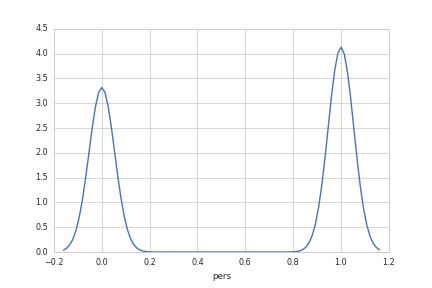

<IPython.core.display.Javascript object>


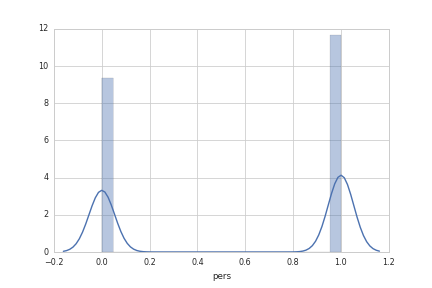

In [197]:
fig = plt.figure()
ax1 = sns.distplot(df_collabs_prefiltered['pers'], kde=False)

fig = plt.figure()
ax2 = sns.distplot(df_collabs_prefiltered['pers'], hist=False)

fig = plt.figure()
ax3 = sns.distplot(df_collabs_prefiltered['pers'])


<IPython.core.display.Javascript object>


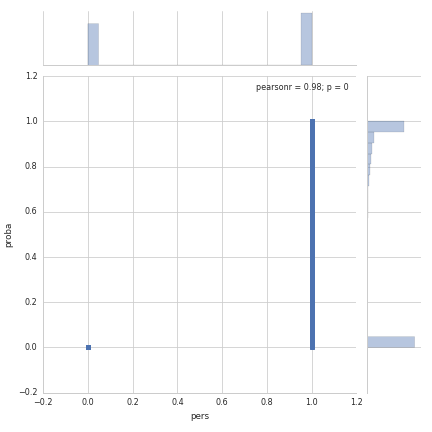

In [198]:
sns.jointplot(x=df_collabs_prefiltered['pers'], y=df_collabs_prefiltered['proba'])